Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [2]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [3]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

# fonction et classe filtering
from kalman import kalman_step
from EKF_class import ExtendedKalmanFilterAstolfi

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.35it/s]


failure in identifying corners
failure in identifying corners
thymio indetectable
thymio indetectable
thymio indetectable
thymio indetectable
thymio indetectable
failure in identifying corners


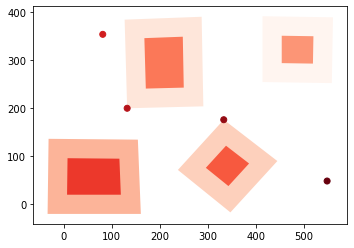

In [4]:
#Open camera
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
frame=vis.takePicture(cap)

#global variables 
state=0 #state of the global FSM
switch_next=0  #FSM for Astolfi
path_iter=1  #next step in the path list = being the starting position
obst = [0,0,0,0,0]   # measurements from front prox sensors
local_motors_speed = [0,0]     # command of the wheels when in local avoidance

#init of Kalman variables, et visualization of trajectory
KF = ExtendedKalmanFilterAstolfi()
KF.set_time_stamp(time.time())
sensor_package = []
kalman_pos = []
coordThym = []
coordKalm = []

#Main Loop
while (cap.isOpened()):
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    #initialization state
    if(state==0):
        corner_coord=vis.find_corners(img)
        img_calibrated=vis.img_calibration(img, corner_coord)
        init=vis.initialization(img_calibrated)
        path=glob.global_pathplanning(init[0],init[1],init[2])
        #initializing the Kalman state vector
        init_pos=[init[0][0],init[0][1]]
        init_angle=init[3]
        KF.init_state_vector(init_pos[0],init_pos[1],init_angle,0,0,0,0,0)
        state=1
    
    #Global navigation state
    if (state==1):
        img_calibrated=vis.img_calibration(img, corner_coord)
        #get all the necessary information for the kalman pose estimation
        pos_thym=vis.detectThymio(img_calibrated)[0]
        angle_thym=vis.directionThymio(img_calibrated)
        vit_roue_gauche, vit_roue_droite = ctrl.read_motors_speed(node,client)
        sensor_package = [pos_thym[0], pos_thym[1], angle_thym, vit_roue_droite, vit_roue_gauche]
        #get the pose estimation and formatting
        E = kalman_step(sensor_package,KF)
        kalman_pos = [E[0], E[1]]
        kalman_pos = np.squeeze(np.asarray(kalman_pos))
        angle_kalman=E[2]
        angle_kalman = np.squeeze(np.asarray(angle_kalman[0]))
        #send the kalman pose estimation to the astolfi controller
        switch_next=ctrl.astolfi(kalman_pos,path[path_iter],angle_kalman,node)
        #check for local avoidance and if it's the case switch state
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        state = local.update_state(state,obst,client) 
        #iterate over global path if thymio reached checkpoint
        if(switch_next==1):
            path_iter=path_iter+1
            #goal reached
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                state=3
    #Local Avoidance state
    if(state==2):
        motor_speed_memory = ctrl.read_motors_speed(node,client)
        local_motors_speed = local.local_nav(prox_horizontal,motor_speed_memory)
        ctrl.set_motors(local_motors_speed[0],local_motors_speed[1],node)
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 1 and state 2
        state = local.update_state(state,obst,client)
        #local avoidance is a blocking state therefore we have to take a new picture and initialize back the kalman state vector
        if state==1:
            ret, frame = cap.read()
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img_calibrated=vis.img_calibration(img, corner_coord)
            pos_thym=vis.detectThymio(img_calibrated)[0]
            angle_thym=vis.directionThymio(img_calibrated)
            KF.init_state_vector(pos_thym[0],pos_thym[1],angle_thym,0,0,0,0,0)

    if state==3:
        break
    
    vis.printGlobalPath(path, img_calibrated)
    vis.printThymio(img_calibrated,kalman_pos,coordKalm)
    final_img = cv2.cvtColor(img_calibrated, cv2.COLOR_RGB2BGR)
    cv2.imshow("Thymio Navigation Visualizer", final_img)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()

In [6]:
ctrl.stopmotors(node)